# Percepción Computacional
## Caso Grupal 3: Implementación y agregación de segmentadores
##### Albert Fernandez Lozano
##### Ander Lanas Alocén
##### Emili Bota Batlle
##### María de la Cruz Ramírez Trujillo
##### Olatz Urrutia Etxebarria
v. 23.02.2021 - 20:00:00

## Introducción

### Objetivos
El objetivo del software desarrollado es facilitar la localización de las pequeñas manchas algodonosas, también llamadas ["cotton wool" spots](https://drlleung.com/blog/f/how-does-diabetic-retinopathy-cause-vision-loss), causadas por la retinopatía diabética eliminando los vasos sanguíneos de la retina.
La metodología utilizada para este fin será la segmentación de imagen, se usarán diferentes algoritmos para ver su comportamiento y empleando un método de votación final para determinar cual de ellos tiene un rendimiento mayor. 
En las conclusiones se expondrán los resultados obtenidos con los distintos segmentadores.

### Dataset
El dataset utilizado proviene de una [base de datos pública](https://www5.cs.fau.de/research/data/fundus-images/) que contiene imágenes de pacientes con retinopatía diabética.

### Importación e inicialización
En los siguientes apartados de código importamos librerías necesarias para facilitar la segmentación (como `skimage`), imágenes del dataset adaptadas (reducidas en tamaño) para nuestro caso y, con estas, sus _ground truths_ (hecho por nosotros mismos) para poder evaluar la certeza de nuestro segmentador resultante.

Finalmente inicializamos varias constantes y funciones de ayuda.

In [1]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import time
from skimage.io import imread
from skimage import data, util, io
from skimage.color import label2rgb,rgb2gray
from skimage.exposure import equalize_adapthist
from skimage.morphology import black_tophat, disk
from skimage.filters import sobel, prewitt, gaussian, threshold_isodata, try_all_threshold
from skimage.segmentation import mark_boundaries, felzenszwalb, slic, quickshift, watershed
from skimage.metrics import adapted_rand_error, variation_of_information

In [2]:
#Importamos la/s imagen/es que queremos utilizar
images = [[]]
ground_truths = [[]]
print('Start loading images...')
for i in np.arange(1,8):
    images.append(imread(f'retinopatia_diabetica/{i:02d}_dr.jpg'))
    ground_truths.append((rgb2gray(imread(f'retinopatia_diabetica/{i:02d}_gt.jpg'))*256).astype('uint8')) #Pasamos de RGB a valores int entre [0-255]
print('All images loaded!')


Start loading images...
All images loaded!


In [3]:
#Constants
IMG = 2 #Cambiar sólo este valor!
ojo = images[IMG]
ojo_gray = equalize_adapthist(rgb2gray(ojo), clip_limit=0.03)
ojo_gt = ground_truths[IMG]

#Segmentos de prueba para SLIC i FELZENSWALB
n_segments = [150,200,250,300]
n_segments_bigger = [300,350,400,450]

In [4]:
def show_by_segments(img,fn,segments):
    """Aplica una función a uma imagen un maximo de 4 veces, con el que se va dando diferentes valores de 'segmentos' para probar el algoritmo dentro de fn"""
    if len(segments) > 4:
        print('Segments too long, we only do 4 in this function')
        return
    fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
    for i, value in enumerate(segments):
        ax[i//2,i%2].imshow(mark_boundaries(img, fn(img,value)),cmap="gray")
        ax[i//2,i%2].set_title(str(value)+" segments")
    

## Pruebas con segmentadores
Para obtener los segmentadores para nuestro caso, utilizamos varias implementaciones (propias y externas) y modificamos sus parámetros para ajustarlo a nuestro objetivo.

### Segmentador 1 - Threshold

Este segmentador pretende diferenciar los píxeles del objeto de los píxeles de su entorno a partir de un umbral que separa en dos partes la imagen, existen diferentes estrategias para elegir el valor de umbral más óptimo, por ejemplo, en nuestro caso usaremos el umbral "isodata".

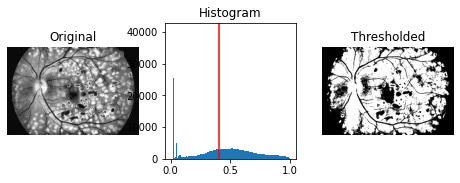

In [5]:
#Threshold segmentator
def threshold_seg(img):
    thresh = threshold_isodata(ojo_gray)
    return ojo_gray > thresh

thres_res = threshold_seg(ojo_gray)
fig, axes = plt.subplots(ncols=3, figsize=(8, 2.5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(ojo_gray, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(ojo_gray.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(threshold_isodata(ojo_gray), color='r')

ax[2].imshow(thres_res, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

plt.show()

### Segmentador 2 - K-means

Este algoritmo de clasificación no supervisada (clusterización) agrupa píxeles en k grupos basandose en sus características. Además, parece adaptarse correctamente a las manchas oscuras pero segmenta bastante la imagen.

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  


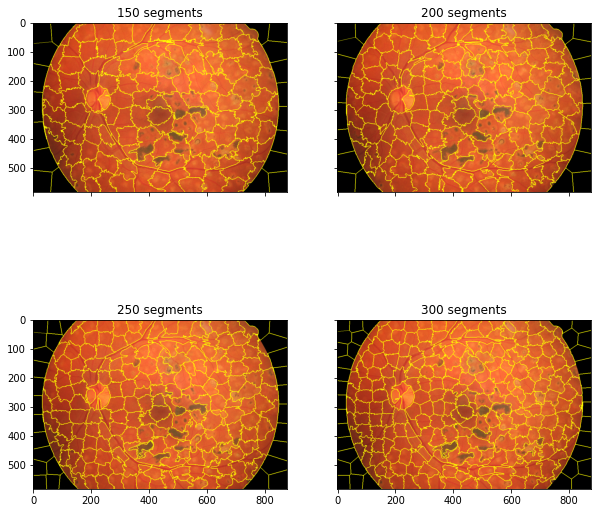

In [6]:
#K-means segmentator
show_by_segments(ojo,(lambda img,sgs: slic(img, n_segments=sgs, compactness=8, convert2lab=True)),n_segments)

### Segmentador 3 - Felzenszwalb
 Se trata de un método basado en grafos, más específicamente MST.

Este parece que con 300 segmentos es el que se adapta mejor a nuestro caso de uso, le daremos un peso mayor en la votación.

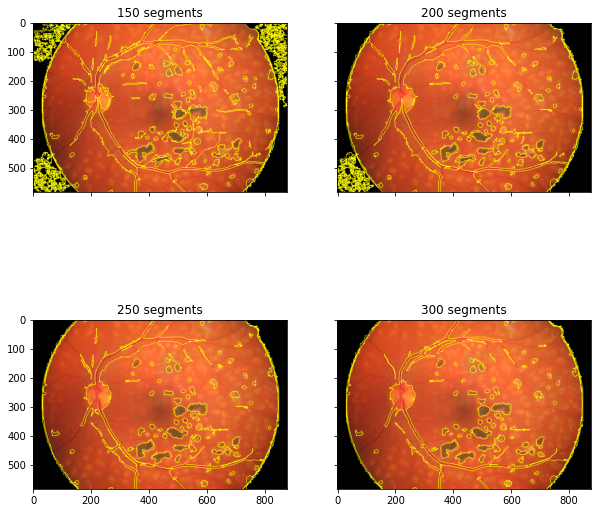

In [7]:
#Felzenszwalb segmentator
show_by_segments(ojo,(lambda img,sgs: felzenszwalb(img, scale=sgs, sigma=0.5, min_size=50)),n_segments)

### Segmentador 4 - Watershed
Hemos probado Watershed con diferentes algoritmos de búsqueda de bordes (para inicializarlo). Nos quedamos con el de sobel, ya que es el que parece que da resultados más ajustados

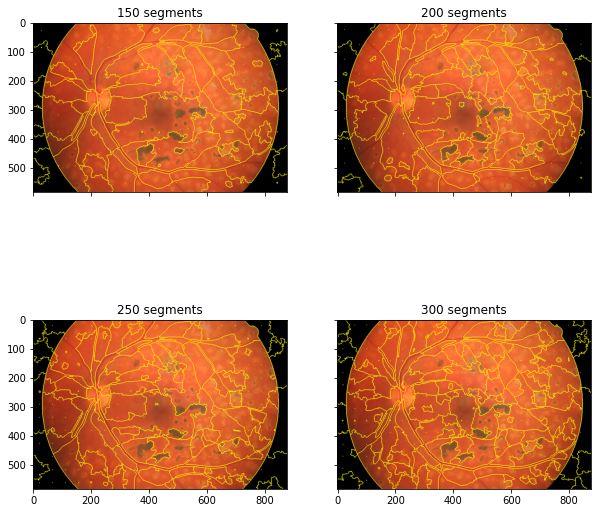

In [8]:
#Watershed V1 (with prewitt border detection)
prewitt_borders = prewitt(ojo_gray)
show_by_segments(ojo,(lambda img,sgs: watershed(prewitt_borders, markers=sgs)),n_segments)

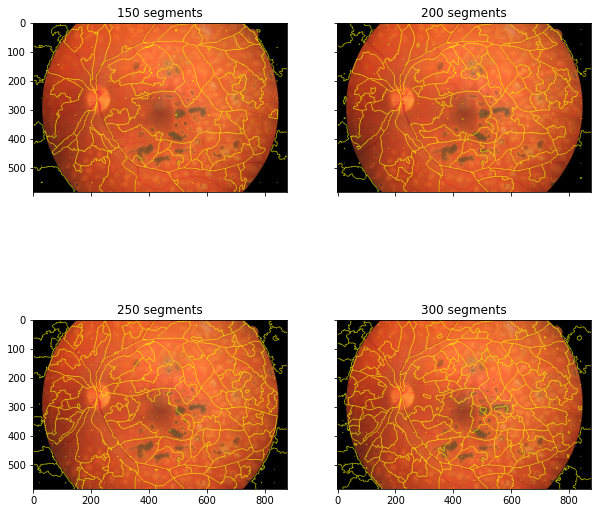

In [9]:
#Watershed V2 (with top-hat border detection)
bth = black_tophat(ojo_gray,disk(5))
show_by_segments(ojo,(lambda img,sgs: watershed(bth, markers=sgs)),n_segments)

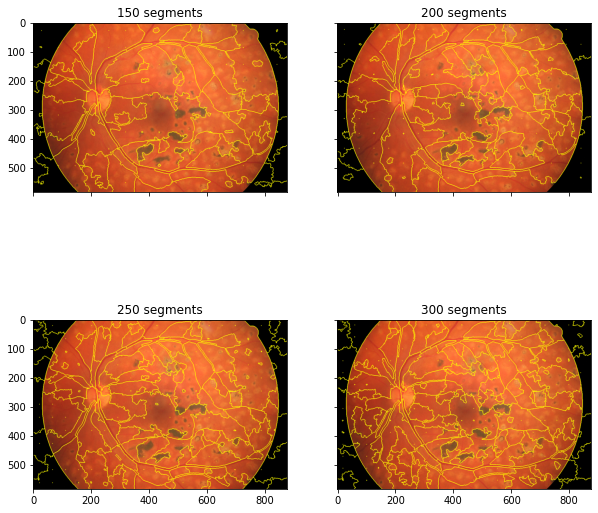

In [10]:
#Watershed V3 (with sobel border detection)
sobel_borders = sobel(ojo_gray)
show_by_segments(ojo,(lambda img,sgs: watershed(sobel_borders, markers=sgs)),n_segments)

### Segmentador 5 - Split and Merge
Hemos implementado nuestra versión del algoritmo Split and Merge con lo que se vió en clase:

Se trata de un algoritmo recursivo, que divide los segmentos en cuatro partes si la varianza de una región sobrepasa un threshold establecido por el usuario. Antes de entrar en la función recursiva, pero, compara los cuatro trozos en parejas para ver si entre ellas són homogeneas (segun la varianza) para asi hacer el merge en lugar de entrar en el bucle recursivo.

Estuvímos manipulando el threshold hasta encontrar uno suficientemente bueno para las imágenes seleccionadas.

Finalmente hace el merge dentro del mismo split (como hemos mencionado), pero no hemos conseguido implementar el merge final que junta regiones vecinas con la misma varianza pero separadas por un split.

/shared-libs/python3.7/py/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/shared-libs/python3.7/py/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/shared-libs/python3.7/py/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


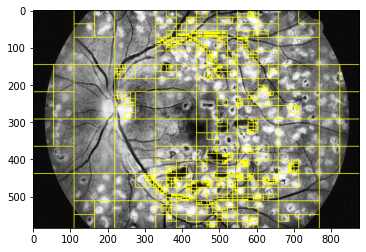

In [11]:
def split_n_merge(img,threshold):
    def homogeneous(region):
        var = np.var(region)
        return var != var or var <= threshold

    def split(region,label):
        last_label = label
        if homogeneous(region):
            last_label += 1
            return np.full(region.shape,last_label), last_label
        else:
            #try:
                #Dividimos la región en cuatro partes
            parts = [0,0,0,0]
            results = [None,None,None,None]
            first_split = np.array_split(region,2, axis=0)
            [ parts[0], parts[1] ] = np.array_split(first_split[0],2,axis=1)
            [ parts[2], parts[3] ] = np.array_split(first_split[1],2,axis=1)
            poss_combinations = [[0,1,1],[2,3,1],[1,3,0],[0,2,0]] #[part1,part2,axis]
            #Miramos si las partes son homogeneas entre si; si lo son, no hacemos split, sino merge
            for possc in poss_combinations:
                if homogeneous(np.concatenate((parts[possc[0]],parts[possc[1]]), axis=possc[2])):
                    act_label = 0
                    if isinstance(results[possc[0]], (list, tuple, np.ndarray)) and results[possc[0]].shape >= (1,1): 
                        act_label = results[possc[0]][0][0]
                    elif isinstance(results[possc[1]], (list, tuple, np.ndarray)) and results[possc[1]].shape >= (1,1):
                        act_label = results[possc[1]][0][0]
                    else:
                        last_label+=1
                        act_label = last_label
                    results[possc[0]] = np.full(parts[possc[0]].shape,last_label)
                    results[possc[1]] = np.full(parts[possc[1]].shape,last_label)
            
            #Finalmente, las partes que no se han mergeado, hacemos split recursivo
            for i,p in enumerate(parts):
                if not isinstance(results[i], (list, tuple, np.ndarray)):
                    results[i], last_label = split(p,last_label)

            return np.concatenate((np.concatenate((results[0],results[1]), axis=1), np.concatenate((results[2],results[3]), axis=1)), axis=0), last_label
            #except ValueError:
            #    print('region shape: '+str(region.shape))
            
            return np.full(region.shape,last_label), last_label

    (splitted,label) = split(img,0)
    return splitted

plt.imshow(mark_boundaries(ojo_gray, split_n_merge(ojo_gray,0.035)),cmap="gray")

### Segmentador 6 - Meanshift
Como último segmentador, probamos el de clusterización Meanshift; como k-means, se adapta perfectamente a las manchas oscuras del ojo, pero sobresegmenta demasiado la imagen.

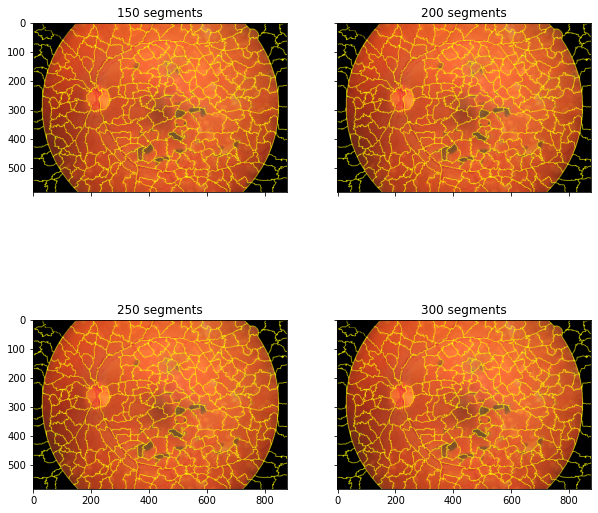

In [12]:
#Meanshift
show_by_segments(ojo,(lambda img,sgs: quickshift(img, kernel_size=5, max_dist=sgs, ratio=0.5)),n_segments)

## Algoritmo de votación
### Primera implementación
Empezamos la implementación de la votación con los parámetros siguientes:

1. Los segmentadores han puesto etiquetas,pero no quiere decir que sean las mismas por un mismo segmento (un mismo segmento reconocido por dos segmentadores, para uno puede tener la etiqueta 1 y para el otro 2)
2. No todos los segmentadores valen igual, hemos podido identificar segmentadoes que se ajustan mejor a nuestro caso, por eso necesitamos darles peso

Con estos, surgió la siguiente idea:

Dar un array con las soluciones de cada segmentador para cada pixel. A partir de ahí, se compara cada pixel con los vecinos, que votan a favor o en contra de la validez de ese array para el segmento. Después de la votación hay dos posibles resultados:
- Si el voto ha resultado **negativo**, se reemplaza el array del pixel por el array que ha votado con más fuerza en contra
- Si el voto ha resultado **positivo**, se reemplaza el array del pixel por el array que ha votado con más fuerza a favor

Estos cambios de array nos permiten mantener un mismo array dentro de un mismo segmento; al finalizar la votación, se le asignará una etiqueta a cada array diferente, así creando el etiquetado de la imagen final.

In [13]:
def biased_votation_v1(arr_seg_results,arr_weight,cicles=1):
    """
    Función de votación de segmentadores (V1)

    Parameters:
    ----------
    arr_seg_results: np.ndarray
        Array con los resultados de los segmentadores
    arr_weight: np.ndarray
        Array con los pesos de los segmentadores (misma longitud que arr_seg_results)
    cicles: int
        Ciclos de votación
    """
    start = time.time()
    print('Start Votation Process V1...')
    shape = arr_seg_results[0].shape
    result = np.empty(shape, dtype=np.ndarray)
    seg_len = np.arange(0,len(arr_seg_results))
    vecinos = [[-1,-1,1],[0,-1,2],[1,-1,1],[-1,0,2],[1,0,2],[-1,1,1],[0,1,2],[1,1,1]]
    ( x , y ) = shape
    height = np.arange(0,x)
    width = np.arange(0,y)
    #Establecemos los arrays de votación para cada pixel de la imagen
    #result = np.stack(arr_seg_results, axis=-1)
    for i in height:
        for j in width:
            result[i][j] = [ labels[i][j] for labels in arr_seg_results ]
    
    print(f'Established Votation Base - {(time.time() - start):.2f} s')
    #Hacemos la votación mirando los vecinos de forma gaussiana
    print('Votation in process...')
    def pixel_votation(actualx,actualy):
        vot_result = 0
        higher_neg_output = (0,0)
        higher_pos_output = (0,0)
        for px,py,pw in vecinos:
            px += actualx
            py += actualy
            if px >= 0 and px < x and py >= 0 and py < y:
                for m in seg_len:
                    pval = result[px][py]
                    value = arr_weight[m] * pw * ( 1 if result[actualx][actualy][m] == pval[m] else -1 )
                    if value > higher_pos_output[0]:
                        higher_pos_output = (value,pval)
                    elif value < higher_neg_output[0]:
                        higher_neg_output = (value,pval)
                    
                    vot_result += value
        return higher_neg_output[1] if vot_result < 0 else higher_pos_output[1]

    for n in np.arange(cicles): #"cicles" numero de pasadas
        cstart = time.time()
        for k in height:    
            for l in width:
                result[k][l] = pixel_votation(k,l)
        print(f'Cicle {n+1}/{cicles} finished in {(time.time() - cstart):.2f} s')
    
    #Establecemos las labels finales, anotando cada array
    print('Labeling final votation...')
    labels = []
    final_segmentation = np.full(arr_seg_results[0].shape,0)
    for t in height:
        for s in width:
            value = 0
            try:
                value = labels.index(result[t][s])
            except ValueError:
                labels.append(result[t][s])
                value = len(labels) - 1
            final_segmentation[t][s] = value
    
    #print(final_segmentation)
    print(f'Finished in {(time.time() - start):.2f} s')
    return final_segmentation

### Segunda implementación
Vimos que el método de votación anterior requería mucho tiempo y los resultados no eran suficientemente buenos (ni con varias modificaciones de éste que probamos)

Así que creamos una nueva función de votación, con un enfoque diferente, similar al graph-cut; en lugar de mirar a los vecinos e ir cambiando el valor de cada píxel con las votaciones de estos, miramos las **conexiones** con los vecinos y cómo de fuerte es la conexión con ellos según los segmentadores, es decir, los segmentadores van a votar la fuerza del vínculo entre píxeles vecinos y para cada píxel, cogemos el píxel vecino con el que tiene el vínculo más fuerte y le asignamos la misma etiqueta.

El voto de un segmentador será positivo o negativo según si en este son o no del mismo segmento, y llevará dos multiplicadores:

1. El grado de conectividad del píxel con el vecino, que le hemos dado un enfoque gaussiano: los vecinos con conectividad-1 tienen valor 2 y los de conectividad-2 tienen valor 1
2. El peso que se le ha dado al segmentador en cuestión: Como mayor sea, mayor será la influencia del segmentador en la votación

In [14]:
def biased_votation_v2(arr_seg_results,arr_weight):
    """
    Función de votación de segmentadores (V2)

    Parameters:
    ----------
    arr_seg_results: np.ndarray
        Array con los resultados de los segmentadores
    arr_weight: np.ndarray
        Array con los pesos de los segmentadores (misma longitud que arr_seg_results)
    """
    start = time.time()
    print('Start Votation Process V2...')
    shape = arr_seg_results[0].shape
    result = np.full(shape,-1) 
    seg_len = np.arange(0,len(arr_seg_results))
    vecinos = [[0,1],[-1,-1],[-1,0],[-1,-1],[0,-1],[1,-1],[1,0],[1,1]]
    ( x , y ) = shape
    height = np.arange(0,x)
    width = np.arange(0,y)
    next_label = 0
    for i in height:
        for j in width:
            fuerza = [] #Potencia de la conexión
            etiqueta = [] #Etiqueta con la que conectar
            for px,py in vecinos:
                pvx = i+px
                pvy = j+py
                #Si existe vecino
                if pvx >= 0 and pvx < x and pvy >= 0 and pvy < y and result[pvx][pvy] != -1:
                    connected = (1 if arr_seg_results[0][i][j] == arr_seg_results[0][pvx][pvy] else -1)
                    for m in seg_len:
                        connected += arr_weight[0] * (1 if arr_seg_results[0][i][j] == arr_seg_results[0][pvx][pvy] else -1)
                    if connected > 0 :
                        fuerza.append(connected)
                        etiqueta.append(result[pvx][pvy])
            print(i,j,fuerza,etiqueta)
            if len(fuerza) > 0:
                result[i][j] = etiqueta[fuerza.index(max(fuerza))]
            else:
                result[i][j] = next_label
                next_label += 1

    print(f'Finished in {(time.time() - start):.2f} s')
    return result

### Tercera implementación
Vimos que el método de votación anterior daba errores. Aún cuando era una votación de un solo segmentador, aparecian lineas horizontales sin sentido. Después de buscar en nuestro código e intentar toda forma de variaciones, vimos el problema: al viajar por los píxeles de forma lineal nos perdíamos possibles relaciones, que resultavan en más labels y por consiguiente más segmentación indeseada en nuestra imagen. Representamos el problema de conectividad:

![](biased_votation_error.png)
Como vemos en la imagen, a la versión 2 le surgen falls en la iteración 3, 5 y 7:
- En la 3a, el elemento no està conectado con ninguna conocida, ya que las iteraciones siguientes, como la 5a (que es su punto de conexión con la label 1) carecen aún de etiqueta.
- En la 5a, se expande el error de la 3a; tiene dos etiquetas con la misma conectividad (1 i 3) y elige la primera (que resulta ser la correcta).
- En la 7a, tenemos un error parecido al de la 3a; las labels 2 que conectan con este elemento aún no has sigo asignadas, por consiguiente se crea una nueva label.

Con este problema, pasamos al tercer y último planteamiento del algoritmo de votación que:
- Recorre la imagen de forma:
    - Lineal: para encontrar possibles píxeles sin label, donde empezar a desarrollar una nueva label (iteraciones 1 i 2 en la imagen)
    - Por Labels: Una vez encontrado un píxel sin label, le asigna uno y mira todos los posibles pixeles vecinos con la misma label (con connectividad), extendiendo así la zona (en la imagen, flechas que salen de las iteraciones)
- Utiliza la función de connectividad de la implementación anterior


In [15]:
def biased_votation_v3(arr_seg_results,arr_weight):
    """
    Función de votación de segmentadores (V3)

    Parameters:
    ----------
    arr_seg_results: np.ndarray
        Array con los resultados de los segmentadores
    arr_weight: np.ndarray
        Array con los pesos de los segmentadores (misma longitud que arr_seg_results)
    """
    start = time.time()
    print('Start Votation Process V3...')
    shape = arr_seg_results[0].shape
    result = np.full(shape,-1) 
    seg_len = np.arange(0,len(arr_seg_results))
    vecinos = [[0,1,2],[-1,-1,1],[-1,0,2],[-1,-1,1],[0,-1,2],[1,-1,1],[1,0,2],[1,1,1]]
    ( x , y ) = shape
    height = np.arange(0,x)
    width = np.arange(0,y)
    next_label = 0

    def add_neighbours(posx,posy):
        res = []
        for px,py,pw in vecinos:
            px += posx
            py += posy
            #Si existe vecino
            if px >= 0 and px < x and py >= 0 and py < y and result[px][py] == -1:
                connected = 0
                for m in seg_len:
                    connected += arr_weight[m] * (1 if arr_seg_results[m][i][j] == arr_seg_results[m][px][py] else -1)
                if connected > 0 :
                    res.append([px,py])
        return res
        
    for i in height:
        for j in width:
            if result[i][j] == -1:
                wait_list = [(i,j)]
                while len( wait_list ) > 0:
                    (px,py) = wait_list.pop(0)
                    if result[px][py] == -1:
                        wait_list = wait_list + add_neighbours(px,py)
                        result[px][py] = next_label
                next_label += 1


    print(f'Finished in {(time.time() - start):.2f} s')
    return result

## Selección y votación final
Procedemos a hacer una selección de los algoritmos de segmentación vistos con lo que creemos que son los mejores parámetros para nuestro caso y seguidamente los hacemos votar una solución utilizando el algoritmo anteriormente explicado. 

In [25]:
selsegstart = time.time()
print('Processing selected segmentation algorithms...')
selected = np.array([felzenszwalb(ojo, scale=300, sigma=0.5, min_size=50),
            slic(ojo, n_segments=300, compactness=8, convert2lab=True),
            threshold_seg(ojo_gray),
            quickshift(ojo, kernel_size=5, max_dist=150, ratio=0.5),
            split_n_merge(ojo_gray,0.035),
            watershed(sobel_borders, markers=300)])
print(f'Finished processing selected segmentation algorithms in {(time.time() - selsegstart):.2f} s')
weights = [9,2,5,3,1,7]

Processing selected segmentation algorithms...
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  after removing the cwd from sys.path.
Finished processing selected segmentation algorithms in 13.74 s


Start Votation Process V3...
Finished in 32.69 s


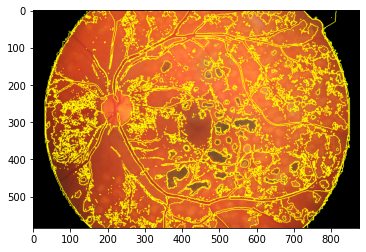

In [26]:
#Creamos la imagen de etiquetas resultante de la votación 
votacion = biased_votation_v3(selected,weights)
plt.imshow(mark_boundaries(ojo,votacion),cmap="gray")

## Evaluación
Finalmente obtenemos lo buena que es la aproximación de cada segmentador utilizado y la votación hecha

In [27]:
#Evaluamos los segmentadores con las herramientas adapted_rand_error y variation_of_information de skimage
selected_names = ['Weighted Votation','Felzenswalb','K-means','Threshold','Meanshift','Split and Merge','Watershed']

for i, labeled_img in enumerate(np.append([votacion],selected,axis=0)):
    error, precision, recall = adapted_rand_error(ojo_gt, labeled_img)
    f1 = 1 - error
    splits, merges = variation_of_information(ojo_gt, labeled_img)
    print(f"\n--> Method: {selected_names[i]} <--")
    print(f"Nota F1: {f1:.6f} [ Precisión: {precision:.6f} ,  Recall: {recall:.6f} ]")
    print(f"Falsos Splits: {splits}\tFalsos Merges: {merges}")



--> Method: Weighted Votation <--
Nota F1: 0.202711 [ Precisión: 0.116738 ,  Recall: 0.769216 ]
Falsos Splits: 4.083715450936444	Falsos Merges: 1.1544225888240585

--> Method: Felzenswalb <--
Nota F1: 0.572023 [ Precisión: 0.464370 ,  Recall: 0.744652 ]
Falsos Splits: 1.661571324529733	Falsos Merges: 1.2400908528574395

--> Method: K-means <--
Nota F1: 0.009966 [ Precisión: 0.005021 ,  Recall: 0.665853 ]
Falsos Splits: 7.0430909238750505	Falsos Merges: 1.2333301090238271

--> Method: Threshold <--
Nota F1: 0.631908 [ Precisión: 0.612698 ,  Recall: 0.652360 ]
Falsos Splits: 0.7058396804952742	Falsos Merges: 1.9043150990533675

--> Method: Meanshift <--
Nota F1: 0.012841 [ Precisión: 0.006483 ,  Recall: 0.662567 ]
Falsos Splits: 6.939200841828704	Falsos Merges: 1.2942743822869154

--> Method: Split and Merge <--
Nota F1: 0.026324 [ Precisión: 0.013423 ,  Recall: 0.675522 ]
Falsos Splits: 6.4383502306704425	Falsos Merges: 1.3483104714386944

--> Method: Watershed <--
Nota F1: 0.030754 [ 

## Conclusiones

Se ha podido observar como actúan los distintos segmentadores en el mismo dataset de imágenes, cada uno tiene su particularidad, algunos potencian más unos aspectos y otros menos. Dependiendo del tipo de imagen y la finalidad de su tratamiento el algorimto será mas eficaz, no existe un algoritmo por excelencia que se adapte a todo.

Si nos centramos en el caso visto en este trabajo demuestra que los segmentadores Threshold y Felzenswalb tienen una precisión mayor al de sus rivales así como una F1 score mucho mayor al resto. Habíamos desarrollado un algoritmo capaz de evaluar el comportamiento de cada segmentador mediante un sistema de votaciones. Esto se logra dándole un rango de "peso" a cada segmentador,y la combinación que obtuviese un mayor F1 sería la mejor. 

El segmentador K-means no logra distinguir eficazmente las venas de las manchas derivadas de la retinopatia diabética, por lo que justifica su  F1 score. Como se puede apreciar en la correspondiente imagen, no logra rodear con eficacia dichas marcas, sino que ocurre un "underfitting" en las zonas detectadas. Ocurre un caso parecido con los casos del segmentador Watershed, Split and Merge y Meanshift. 

Finalmente, acabamos con una segmentación por votación mejor a la media de nota de los segmentadores seleccionados, aunque es mejorable mediante la calibración de los pesos y/o más ajustes en los parámetros de los segmentadores seleccionados.